# **Harris Corner Detector**

Corner detection is a fundamental aspect of computer vision and the Harris Corner Detector is a simple yet highly relevant corner detection method. In this notebook, we will learn how to implement Harris Corner Detection from scratch on several test images so that we can gain a full understanding of it.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Create Test Images

In [681]:
N = 256 # image size

awgn = np.random.normal(0, 5, (N, N))
flat_image = np.zeros((N, N))

horz_image = flat_image.copy()
horz_image[0:N//2, :] = 255

vert_image = flat_image.copy()
vert_image[:, 0:N//2] = 255

corner = flat_image.copy()
corner[0:N//2, 0:N//2] = 255

blunt_corner = flat_image.copy()
pts = np.array([(0,0), (0, N//2+30), (N//2, N//2), (N, 0)]).reshape((-1, 1, 2))
cv2.fillPoly(blunt_corner, [pts], color=(255,))

sharp_corner = flat_image.copy()
tri_pts = np.array([(0,0), (0, N//2-50), (N//2, N//2)]).reshape((-1, 1, 2))
cv2.fillPoly(sharp_corner, [tri_pts], color=(255,))


# add abs value noise and 0-1 normalize
flat_image += np.abs(awgn)
horz_image += np.abs(awgn)
vert_image += np.abs(awgn)
corner += np.abs(awgn)
blunt_corner += np.abs(awgn)
sharp_corner += np.abs(awgn)

flat_image /= flat_image.max()
horz_image /= horz_image.max()
vert_image /= vert_image.max()
corner /= corner.max()
blunt_corner /= blunt_corner.max()
sharp_corner /= sharp_corner.max()

Display test images

Text(0.5, 1.0, 'Sharp Corner')

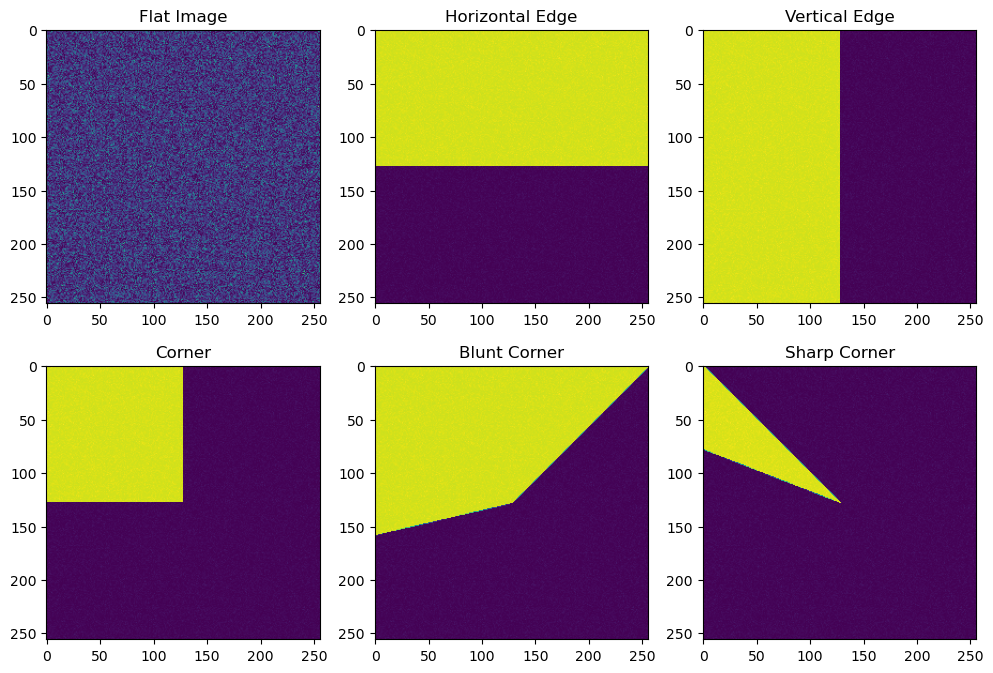

In [682]:
_, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].imshow(flat_image)
ax[0, 0].set_title("Flat Image")

ax[0, 1].imshow(horz_image)
ax[0, 1].set_title("Horizontal Edge")

ax[0, 2].imshow(vert_image)
ax[0, 2].set_title("Vertical Edge")

ax[1, 0].imshow(corner)
ax[1, 0].set_title("Corner")

ax[1, 1].imshow(blunt_corner)
ax[1, 1].set_title("Blunt Corner")

ax[1, 2].imshow(sharp_corner)
ax[1, 2].set_title("Sharp Corner")

# **Harris Corner Detection Pipeline**

Now we will create a pipeline to implement Harris Corner Detection from scratch. In this notebook, we will only compute the corner response from scratch and use opencv functions to find the best corners based on the Harriso corner response.

<br>

First we will need to set some hyperparameters for the Harris detection. 

In [751]:
k = 0.05
thresh = 0.5

We will also set up Sobel Kernels to compute the first derivatives of the image as well as a Gaussian Kernel to handle the Gaussian Windowing. We will also compare the Gaussian Window to the block window and see how the noise is reduced.

In [733]:
# Sobel kernels
Sx = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]])

Sy = Sx.T

# Gaussian Kernel
G = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])/16

Now construct the pipeline function

In [734]:
def corner_response(image, k=k):
    # compute first derivatives
    dx = cv2.filter2D(image, ddepth=-1, kernel=Sx)
    dy = cv2.filter2D(image, ddepth=-1, kernel=Sy)

    # Gaussian Filter
    A = cv2.filter2D(dx*dx, ddepth=-1, kernel=G)
    B = cv2.filter2D(dy*dy, ddepth=-1, kernel=G)
    C = cv2.filter2D(dx*dy, ddepth=-1, kernel=G)

    # compute corner response at all pixels
    return (A*B - (C*C)) - k*(A + B)*(A + B)

### Compute Corner Response for all images

In [735]:
R_flat = corner_response(flat_image)
R_horz = corner_response(horz_image)
R_vert = corner_response(vert_image)
R_corner = corner_response(corner)
R_blunt_corner = corner_response(blunt_corner)
R_sharp_corner = corner_response(sharp_corner)

Text(0.5, 1.0, 'Sharp Corner')

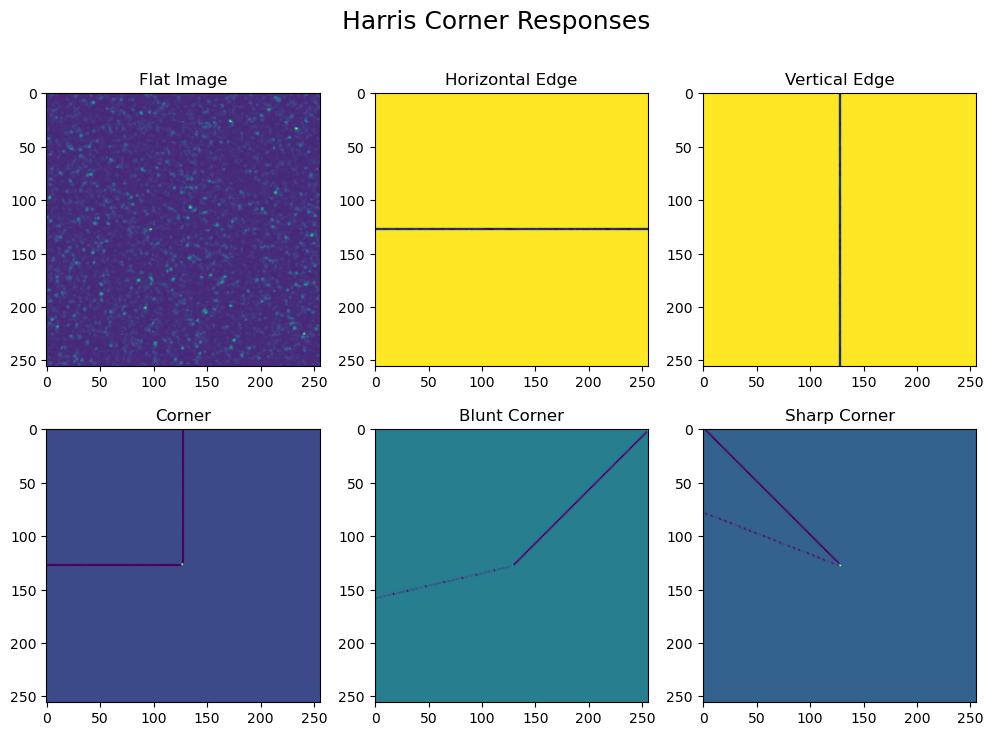

In [736]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Harris Corner Responses", size=18)

ax[0, 0].imshow(R_flat)
ax[0, 0].set_title("Flat Image")

ax[0, 1].imshow(R_horz)
ax[0, 1].set_title("Horizontal Edge")

ax[0, 2].imshow(R_vert)
ax[0, 2].set_title("Vertical Edge")

ax[1, 0].imshow(R_corner)
ax[1, 0].set_title("Corner")

ax[1, 1].imshow(R_blunt_corner)
ax[1, 1].set_title("Blunt Corner")

ax[1, 2].imshow(R_sharp_corner)
ax[1, 2].set_title("Sharp Corner")

In [746]:
R_horz.min()

-5.578224510681783

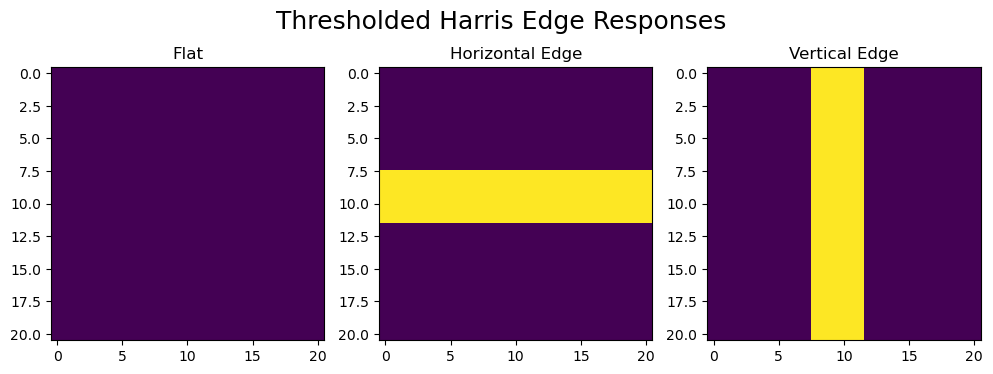

In [750]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Thresholded Harris Edge Responses", size=18)

# get slice window
w_sz = 10
s = slice(N//2-w_sz,N//2+w_sz+1)

ax[0].imshow((R_flat < -thresh)[s,s])
ax[0].set_title("Flat")

ax[1].imshow((R_horz < -thresh)[s,s])
ax[1].set_title("Horizontal Edge")

ax[2].imshow((R_vert < -thresh)[s,s])
ax[2].set_title("Vertical Edge");

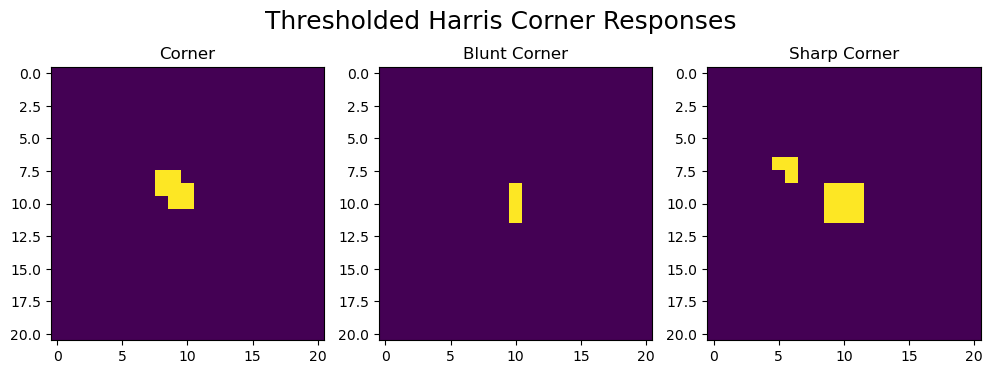

In [737]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Thresholded Harris Corner Responses", size=18)

# get slice window
w_sz = 10
s = slice(N//2-w_sz,N//2+w_sz+1)

ax[0].imshow((R_corner > thresh)[s,s])
ax[0].set_title("Corner")

ax[1].imshow((R_blunt_corner > thresh)[s,s])
ax[1].set_title("Blunt Corner")

ax[2].imshow((R_sharp_corner > thresh)[s,s])
ax[2].set_title("Sharp Corner");

In [731]:
dx = cv2.filter2D(corner, ddepth=-1, kernel=Sx)
dy = cv2.filter2D(corner, ddepth=-1, kernel=Sy)

# place window around center of image
w_sz = 10
s = slice(N//2-w_sz,N//2+w_sz+1)
dx_win = dx[s, s]
dy_win = dy[s, s]

# center data
dx_win -= dx_win.mean()
dy_win -= dy_win.mean()

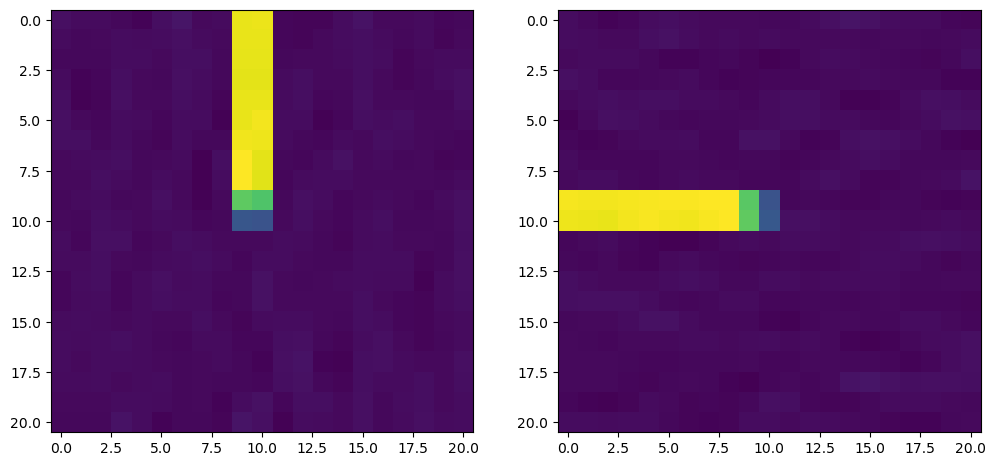

In [708]:
_, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(dx_win)
ax[1].imshow(dy_win);

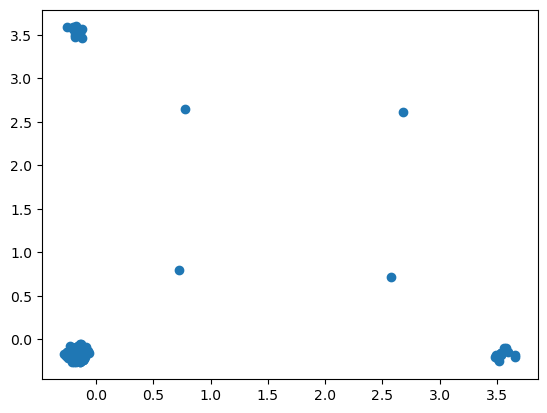

In [752]:
plt.scatter(dx_win.flatten(), dy_win.flatten());

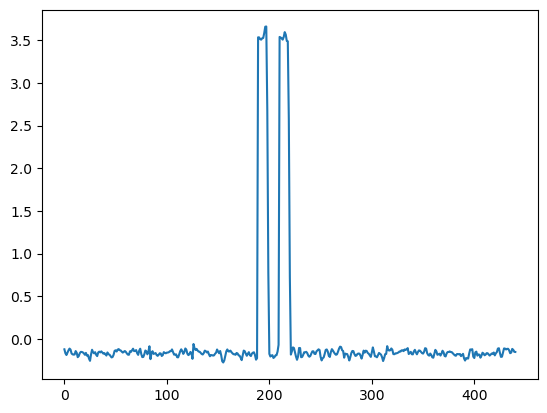

In [741]:
plt.plot(dx_win.T.flatten())

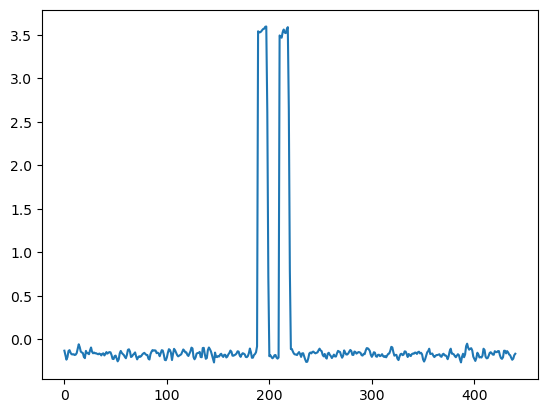

In [739]:
plt.plot(dy_win.flatten())

### **Study Eigenvalues of M matrix at the center pixels**

In [703]:
test_images = {
    'Flat Image' : flat_image,
    'Horizontal Edge' : horz_image,
    'Vertical Edge' : vert_image,
    'Corner' : corner,
    'Blunt Corner' : blunt_corner,
    'Sharp Corner' : sharp_corner
}

[[ 0.53820812 -0.03244924]
 [-0.03244924  0.22288412]]
[[4.12410621e-03 5.14606286e-02]
 [5.14606286e-02 1.03280218e+01]]
[[1.04597615e+01 3.23200545e-03]
 [3.23200545e-03 1.71589112e-03]]
[[5.79289439 2.6358087 ]
 [2.6358087  5.7375218 ]]
[[0.35940593 0.68839415]
 [0.68839415 3.20468792]]
[[ 4.32697095 -4.06645733]
 [-4.06645733  5.84201134]]


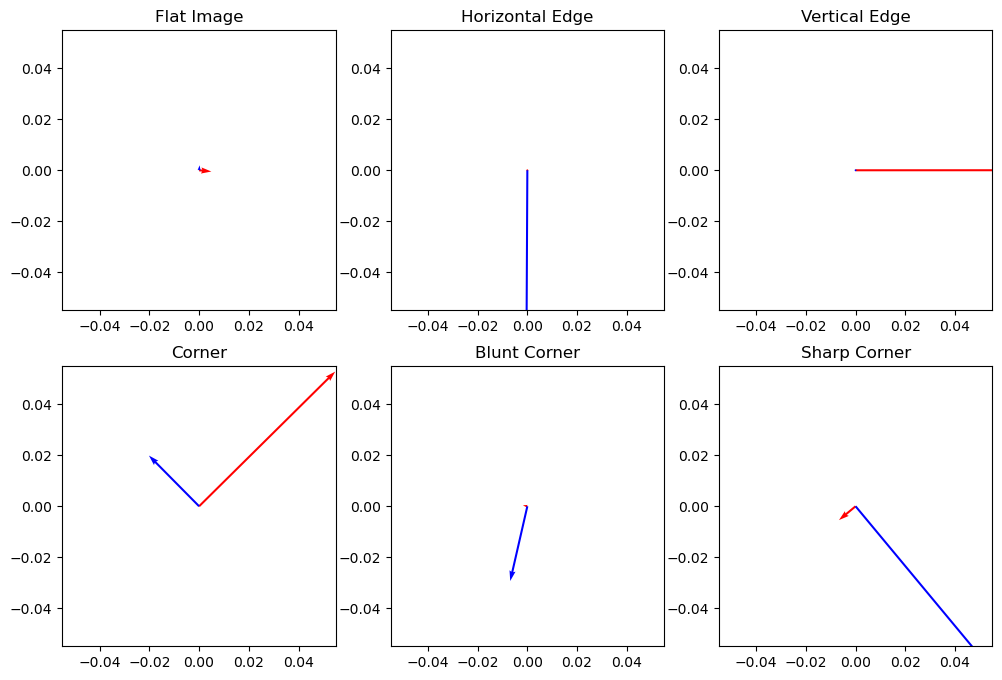

In [742]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

x, y = N//2 - 1, N//2 - 1

for i, (k, img) in enumerate(test_images.items()):
    dx = cv2.filter2D(img, ddepth=-1, kernel=Sx)
    dy = cv2.filter2D(img, ddepth=-1, kernel=Sy)

    A = cv2.filter2D(dx*dx, ddepth=-1, kernel=G)
    B = cv2.filter2D(dy*dy, ddepth=-1, kernel=G)
    C = cv2.filter2D(dx*dy, ddepth=-1, kernel=G)

    M = np.array([[A[x, y], C[x, y]],
                  [C[x, y], B[x, y]]])

    print(M)

    (alpha, beta), v = np.linalg.eig(M)

    if i < 3:
        ax[0, i].quiver(*[0, 0], *v[:,0]*alpha, color=['r'], scale=12)
        ax[0, i].quiver(*[0, 0], *v[:,1]*beta, color=['b'], scale=12)
        ax[0, i].set_title(k);
    else:
        ax[1, i-3].quiver(*[0, 0], *v[:,0]*alpha, color=['r'], scale=12)
        ax[1, i-3].quiver(*[0, 0], *v[:,1]*beta, color=['b'], scale=12)
        ax[1, i-3].set_title(k);